# PyTorch Workflow

The PyTorch end-to-end workflow

Resources:
* Github Repo - https://github.com/mrdbourke/pytorch-deep-learning
* Web Version - https://www.learnpytorch.io/01_pytorch_workflow/

In [1]:
what_were_covering = {1: "data (prepare and load)",
                    2: "build model",
                    3: "fitting the model to data (training)",
                    4: "making prediction and evaluating (inference)",
                    5: "saving and loading a model",
                    6: "putting it together"}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making prediction and evaluating (inference)',
 5: 'saving and loading a model',
 6: 'putting it together'}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch Version
print(torch.__version__)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1


## 1. Data (preparing and loading)

Data can be almost anything in machine learning

* Excel Spreadsheet
* Images of any kind
* Videos (youtube etc.)
* Audio (songs, podcasts)
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with *known* **parameters**.

In [3]:
# Create known parameters
# f(x) = a + bx
weight = 0.7
bias = 0.3

# Create Inputs
start = 0
end = 1
step = 0.02

# add extra bracket (dim) to X
X = torch.arange(start, end, step).unsqueeze(dim=1) # uppercase = matrix || tensor

# output per input
y = weight * X + bias # lowercase = vector

# X[:10], y[:10], len(X), len(y)

### Splitting data into training and test sets
1. Training Set (60~80%)
2. Validation Set (10~20%)
3. Testing Set (10~20%)


In [4]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# this method doesn't have any randomness since we're manually splitting the data
# but we can use scikit learn split method to improve this later

len(X_train), len(y_train), len(X_test), len(y_test) 

(40, 40, 10, 10)

In [5]:
# how to visualize data
# X_train, y_train
# not intuitive

### How can be better visualize our data?
### "Visualize, visualize, visualize!"

In [6]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    """
    Plots training data, test data and compares predictions.
    """

    plt.figure(figsize = (10, 7))

    # plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

    # plot training data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

    # are there predictions?
    # modify if-statement as need be
    if predictions is not None:
        # plot the predictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # show the legend
    plt.legend(prop={"size": 14})

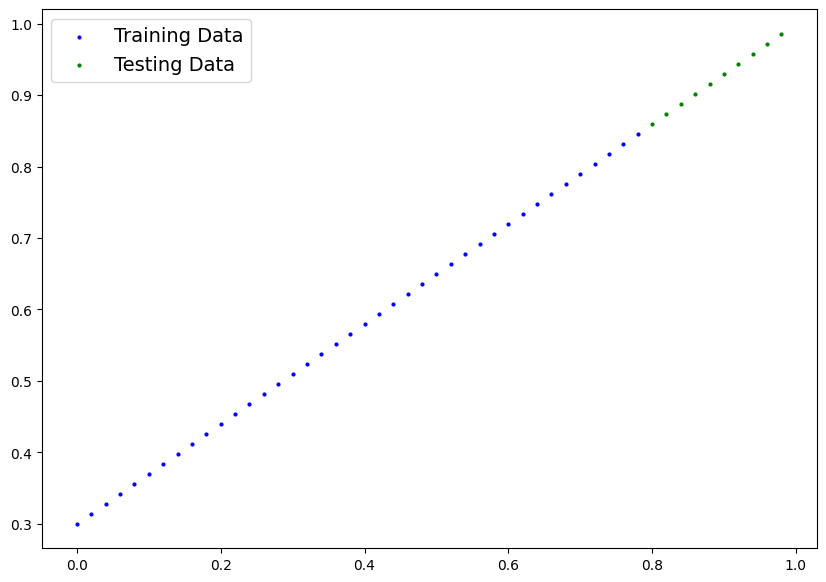

In [7]:
# the arguments are hard-coded
plot_predictions()

## 2. Build Model

In [8]:
# create linear regression model class
# import module (nn stands for neural network)
from torch import nn

class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherits from nn.Module
    
    # constructor
    def __init__(self):
        super().__init__() # inheritance
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float)) # pytorch is default float32
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        
    # forward propagation
    # x is the input data (=training set)
    # arrow indicates the return type
    def forward(self, x: torch.Tensor) -> torch.Tensor: # override
        # use the linear regression formula
        return self.weights * x + self.bias

### Checking the contents of our PyTorch Model

Now we've created a model, let's see what's inside.
We can check our model parameters using `.parameters()`.

In [9]:
# create random seed
# fix the random generator
torch.manual_seed(42)

# create an instance of the model (subclass of nn.Module)
model_0 = LinearRegressionModel()

# check out the parameters
list(model_0.parameters())

# the bias and weight parameter each produce one random tensor

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using torch.inference.mode()

To check our model's predictive power, let's see how well it predict `y_test` based on `X_test`.
When we pass data through our model, it's going to run it through the `forward()` method.

In [11]:
# X_test, y_test

* x_train:
    - training data for the model
    - initial input data to optimize the weight and bais parameters
* y_train:
    - the answer (fixed output) corresponding to the x_train inputs
    - directly related to loss function by showing "how off" the predictions are
* x_test:
    - new data for the model to test on
* y_test:
    - the answer corresponding to the x_test inputs
    - high accuracy in y_test is what the model is aiming for

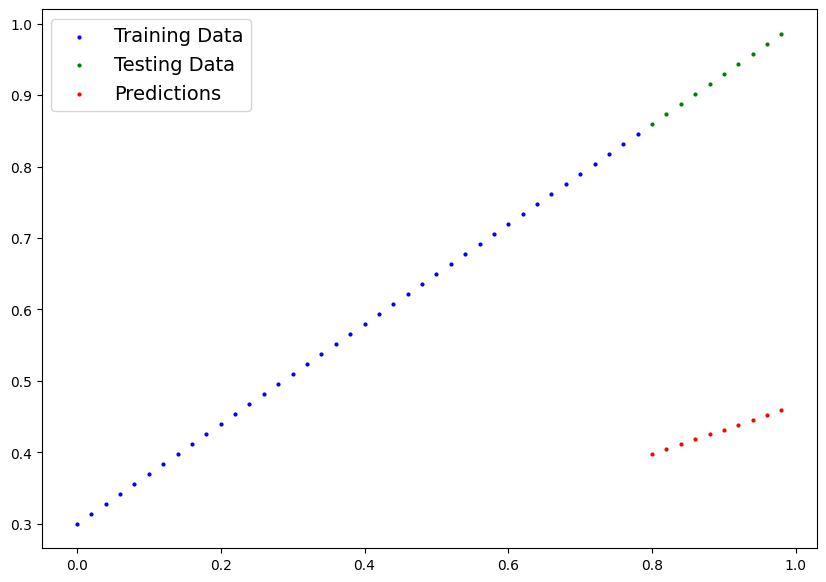

In [12]:
# make predictions with model
# inference_mode disables gradient functionality
with torch.inference_mode():
    y_predicts = model_0(X_test)

# y_predicts

plot_predictions(predictions=y_predicts)

## 3. Train Model

The whole idea of training is for a model to move from some *unknown* parameters to *known* parameters. This is equivalent to improving poor representation.

It is crucial to measure how poor or wrong the current model's predictions are. We will use the loss function to measure this.

**Things we need to train:**
* **Loss Function:** A function to measure how wrong the model's predictions are to the ideal outputs. Lower is better. Our job is to reduce the error.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (i.e. weight & bias)


**For PyTorch we need:**
* A `Training` Loop
* A `Testing` Loop

In [13]:
# print(model_0.parameters())
# print(list(model_0.parameters()))
# print(model_0.state_dict())

In [14]:
# setup loss function
loss_fn = nn.L1Loss() # how wrong our model is
print(loss_fn)

# goal: minimize mean square error

# setup optimizer (stochasic gradient descent)
# fixes the 'wrongness' of our model
# lr = learning rate = hyperparameter
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

L1Loss()


**Q:** Which loss function and optimizer should I use?

**A:** This will be problem specific. But with experience, you'll get an idea of what works and what doens't with your particular problem set.

For example, for a regression problem (like this example), a loss function `nn.L1Loss()` and an optimizer like `torch.optim.SGD` will suffice.

But for a classification problem like classifying whether a photo is of a dog or a cat, you'll likely want to use a loss function of `nnBCELoss()` (binary cross entropy loss).

In [15]:
from torch import nn

# PREDICTION MODEL

class LinearRegressionModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return self.weights * x + self.bias

In [16]:
# INPUT DATA & SETUP

weight, bias = 0.7, 0.3
start, end, step = 0, 1, 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

torch.manual_seed(11)
model_0 = LinearRegressionModel()
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

print(model_0.state_dict())

OrderedDict([('weights', tensor([0.7376])), ('bias', tensor([1.9459]))])


In [17]:
# an epoch is one loop through data
# epochs = 100000
torch.manual_seed(11)
epochs = 200

# track different valus
epoch_count = []
loss_values = []
test_loss_values = []

# 0. loop through the data
for epoch in range(epochs):
    # set model to training mode
    # tracks and updates gradients
    model_0.train()

    # 1. forward pass
    y_predicts = model_0(X_train)

    # 2. calculate loss
    loss = loss_fn(y_predicts, y_train)
    # print(f"Loss: {loss}")

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. backpropagation
    loss.backward()

    # 5. gradient descent
    optimizer.step()

    # evaluate
    model_0.eval() # turns off settings unnecessary for testing (dropout/normalization)
    with torch.inference_mode(): # turn off gradient tracking
        test_pred = model_0(X_test) # forward pass using "test" data
        test_loss = loss_fn(test_pred, y_test) # calculate loss

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

# print model loss &state_dict()
# print(f"Loss: {loss}")
# print(f"State: {model_0.state_dict()}")

Epoch: 0 | Loss: 1.66060471534729 | Test Loss: 1.665948510169983
Epoch: 10 | Loss: 1.545394778251648 | Test Loss: 1.5312385559082031
Epoch: 20 | Loss: 1.4301848411560059 | Test Loss: 1.3965288400650024
Epoch: 30 | Loss: 1.3149750232696533 | Test Loss: 1.2618190050125122
Epoch: 40 | Loss: 1.1997652053833008 | Test Loss: 1.1271090507507324
Epoch: 50 | Loss: 1.0845553874969482 | Test Loss: 0.9923993349075317
Epoch: 60 | Loss: 0.9693454504013062 | Test Loss: 0.857689380645752
Epoch: 70 | Loss: 0.8541356325149536 | Test Loss: 0.7229796051979065
Epoch: 80 | Loss: 0.7389256954193115 | Test Loss: 0.5882697701454163
Epoch: 90 | Loss: 0.6237158179283142 | Test Loss: 0.4535599648952484
Epoch: 100 | Loss: 0.5085060000419617 | Test Loss: 0.3188501000404358
Epoch: 110 | Loss: 0.3932960629463196 | Test Loss: 0.18414029479026794
Epoch: 120 | Loss: 0.27808621525764465 | Test Loss: 0.04943046718835831
Epoch: 130 | Loss: 0.1650274693965912 | Test Loss: 0.08191774785518646
Epoch: 140 | Loss: 0.11822468042

In [33]:
# print(loss_values)
# print(torch.tensor(loss_values))

[tensor(1.6606, grad_fn=<MeanBackward0>), tensor(1.5454, grad_fn=<MeanBackward0>), tensor(1.4302, grad_fn=<MeanBackward0>), tensor(1.3150, grad_fn=<MeanBackward0>), tensor(1.1998, grad_fn=<MeanBackward0>), tensor(1.0846, grad_fn=<MeanBackward0>), tensor(0.9693, grad_fn=<MeanBackward0>), tensor(0.8541, grad_fn=<MeanBackward0>), tensor(0.7389, grad_fn=<MeanBackward0>), tensor(0.6237, grad_fn=<MeanBackward0>), tensor(0.5085, grad_fn=<MeanBackward0>), tensor(0.3933, grad_fn=<MeanBackward0>), tensor(0.2781, grad_fn=<MeanBackward0>), tensor(0.1650, grad_fn=<MeanBackward0>), tensor(0.1182, grad_fn=<MeanBackward0>), tensor(0.1040, grad_fn=<MeanBackward0>), tensor(0.0976, grad_fn=<MeanBackward0>), tensor(0.0933, grad_fn=<MeanBackward0>), tensor(0.0896, grad_fn=<MeanBackward0>), tensor(0.0861, grad_fn=<MeanBackward0>)]
tensor([1.6606, 1.5454, 1.4302, 1.3150, 1.1998, 1.0846, 0.9693, 0.8541, 0.7389,
        0.6237, 0.5085, 0.3933, 0.2781, 0.1650, 0.1182, 0.1040, 0.0976, 0.0933,
        0.0896, 0.0

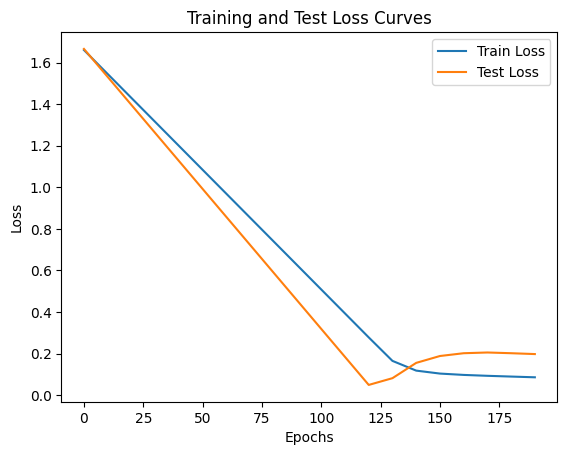

In [34]:
import numpy as np

# plot loss curve

# variables are set to pytorch tensors
# we need to change type from tensor to numpy array
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test Loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [35]:
with torch.inference_mode():
    y_predicts_model = model_0(X_test)

print(model_0.state_dict())

OrderedDict([('weights', tensor([0.2889])), ('bias', tensor([0.4724]))])


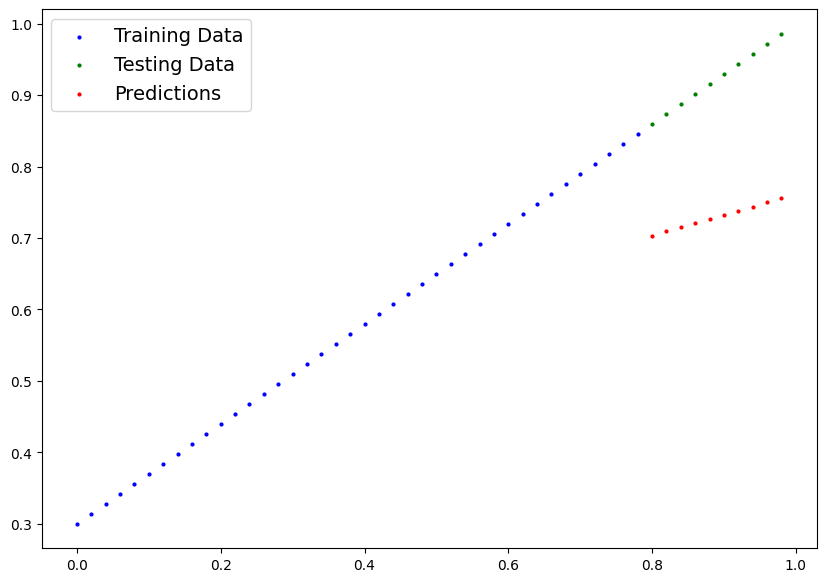

In [36]:
# restart the program if you want to clear all existing data
# or the model will continue the training on the most recently updated parameters
plot_predictions(predictions=y_predicts_model)